<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-задачи" data-toc-modified-id="Описание-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание задачи</a></span></li><li><span><a href="#Импорты" data-toc-modified-id="Импорты-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импорты</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Предобработка</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Бинарная-классификация" data-toc-modified-id="Бинарная-классификация-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Бинарная классификация</a></span></li></ul></li></ul></div>

### Описание задачи

 **Задание №3**. Постройте прогнозую модель для датасета с UCI Machine Learning: предобработайте категориальные фичи, отберите их, соберите схему валидации и отберите модели с помощью нее. Описание датасета по ссылке: https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

### Импорты

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.dummy import DummyClassifier

import optuna
import logging
import warnings
from sklearn.metrics import classification_report
from tqdm import tqdm

Глобальные переменные


In [2]:
RANDOM_STATE = 12345

### Загрузка данных

In [3]:
data = pd.read_csv('sberbank/drug_consumption.data', header=None, index_col=0)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [4]:
print(data.shape)
display(data.describe())

(1885, 31)


,1,2,3,4,5,6,7,8,9,10,11,12
count,1885.00000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.03461,-0.000256,-0.003806,0.355542,-0.309577,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,0.87836,0.482588,0.950078,0.700335,0.166226,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,-0.95197,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,-0.95197,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,-0.07854,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,0.49788,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,2.59171,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


Судя по описанию датасета по ссылке и тому что мы видим. наши данные нормализованы и являются категориальными

Создадим словарь для работы с колонками

In [5]:
dict_cols = {1:'Age',2:'Gender',3:'Education',4:'Country',5:'Ethnicity',6:'Nscore',7:'Escore',8:'Oscore',9:'Ascore',10:'Cscore',
             11:'Impulsive',12:'SS',13:'Alcohol ',14:'Amphet',15:'Amyl',16:'Benzos',17:'Caff',
             18:'Cannabis',19:'Choc',20:'Coke',21:'Crack',22:'Ecstasy',23:'Heroin',24:'Ketamine',
             25:'Legalh',26:'LSD',27:'Meth',28:'Mushrooms',29:'Nicotine',30:'Semer',31:'VSA'
            }




### Предобработка

In [6]:
def set_categorical(data,threshold=50):
    '''
    searching and setting column types to categorical
    threshold - maximum number of distinct values to be considered as categorical
    '''
    for col in data.columns:
        if data[col].nunique() <= threshold:
            data[col]= data[col].astype('category')
    return data

In [7]:
data=set_categorical(data)

In [8]:
def clean_from_nans_and_duplicates(df,threshold = 0.45):
    '''
    cleaning data from columns with nans()
    threshold 0.45 was taken knowing that we cannot do anything with features
    with more than 0.45 nans when we don't know what the column is about
    
    '''
    
 

    print(f'Number of columns with count of Nans more than {threshold} samples' ,len(df.isnull().mean().sort_values().loc[lambda x:x>threshold]))
    df=df.drop(columns=df.isnull().mean().sort_values().loc[lambda x:x>threshold].index)
    print(f'Number of columns with count of Nans more than {threshold} samples after deleting' ,len(df.isnull().mean().sort_values().loc[lambda x:x>threshold]))
    
    print('Number of duplicated samples within dataset:', len(df.loc[lambda x:x.duplicated()]))
    
    df=df.drop_duplicates()
    print('Number of duplicated samples within dataset after dropping:', len(df.loc[lambda x:x.duplicated()]))
    
    return df


def clean_from_constans(df):
    '''
    cleaning data from features that are all the same. But there should not 
    be NaNs inside. LGBM CLassifier probably would find some logic in it
    '''
    # Get the number of unique values for each feature
    unique_counts = df[df.isnull().mean().sort_values().loc[lambda x:x==0].index].nunique()

    # Get the names of the constant features
    constant_feature_names = unique_counts[unique_counts == 1].index

    # Print the names of the constant features
    print("Constant features:", constant_feature_names)
    print('Shape of dataframe before deleting cosntant features:', df.shape)

    # Remove the constant features from the training data
    df = df.drop(columns=constant_feature_names)
    
    print('Shape of dataframe after deleting cosntant features:', df.shape)
    
    return df



def clean_from_correlation(df,threshold=0.95):
    '''
    Function cleans data from highly correlated features
    '''
    
    print(f'Shape of dataframe before deleting features with more than {threshold} correlation:',df.shape)
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features 
    df=df.drop(to_drop, axis=1)
    
    print(f'Shape of dataframe after deleting features with more than {threshold} correlation:',df.shape)
        
    return df

In [9]:
data=clean_from_nans_and_duplicates(data)
data=clean_from_constans(data)
data =clean_from_correlation(data)

Number of columns with count of Nans more than 0.45 samples 0
Number of columns with count of Nans more than 0.45 samples after deleting 0
Number of duplicated samples within dataset: 0
Number of duplicated samples within dataset after dropping: 0
Constant features: Int64Index([], dtype='int64')
Shape of dataframe before deleting cosntant features: (1885, 31)
Shape of dataframe after deleting cosntant features: (1885, 31)
Shape of dataframe before deleting features with more than 0.95 correlation: (1885, 31)
Shape of dataframe after deleting features with more than 0.95 correlation: (1885, 31)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1885 entries, 1 to 1888
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   1       1885 non-null   category
 1   2       1885 non-null   category
 2   3       1885 non-null   category
 3   4       1885 non-null   category
 4   5       1885 non-null   category
 5   6       1885 non-null   category
 6   7       1885 non-null   category
 7   8       1885 non-null   category
 8   9       1885 non-null   category
 9   10      1885 non-null   category
 10  11      1885 non-null   category
 11  12      1885 non-null   category
 12  13      1885 non-null   category
 13  14      1885 non-null   category
 14  15      1885 non-null   category
 15  16      1885 non-null   category
 16  17      1885 non-null   category
 17  18      1885 non-null   category
 18  19      1885 non-null   category
 19  20      1885 non-null   category
 20  21      1885 non-null   category
 21  22      1885 n

### EDA

Проведем ускоренный анализ данных


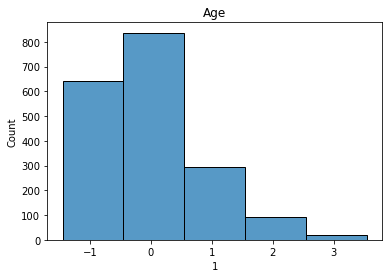

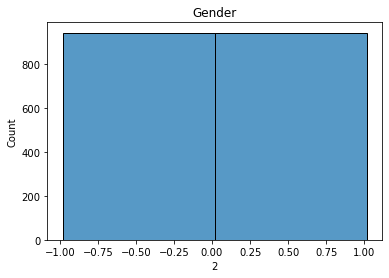

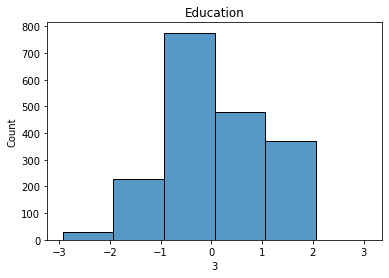

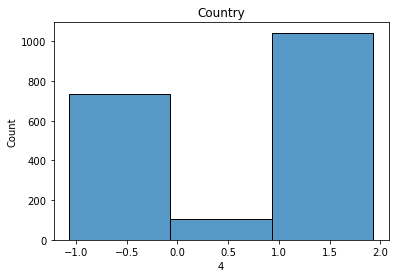

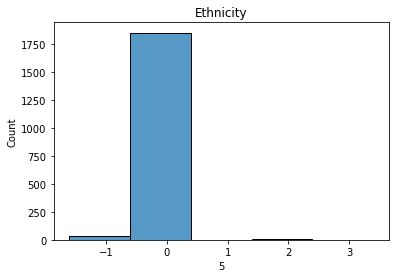

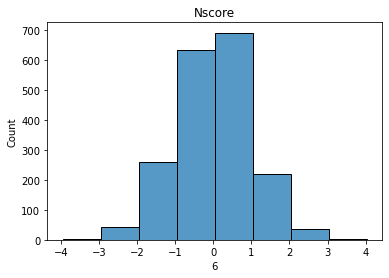

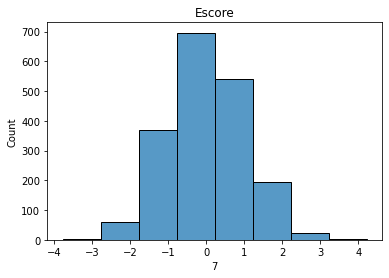

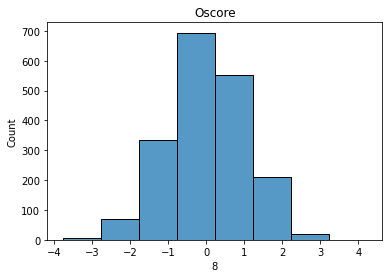

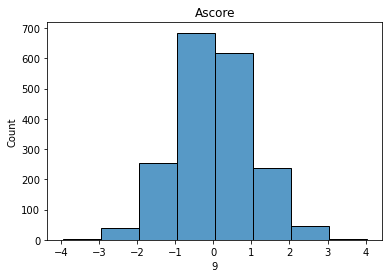

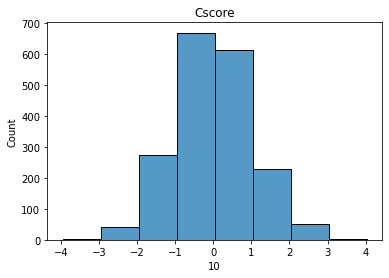

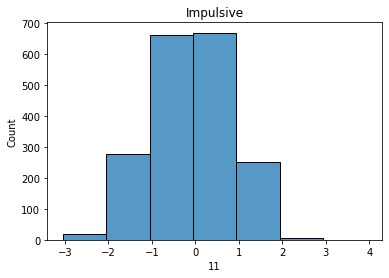

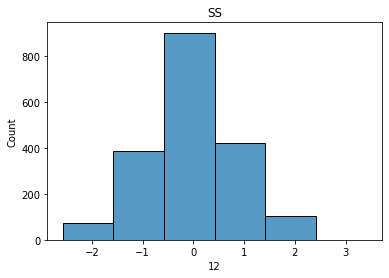

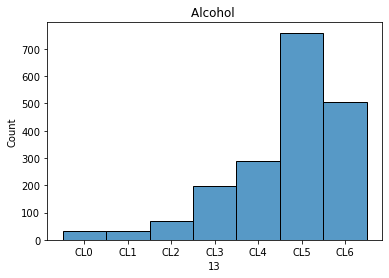

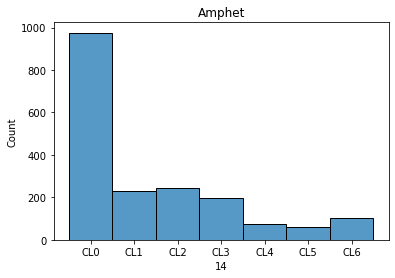

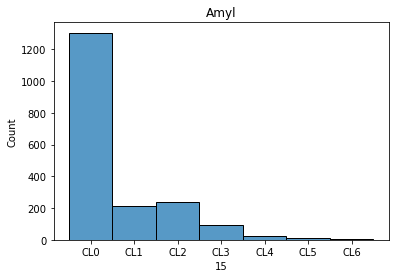

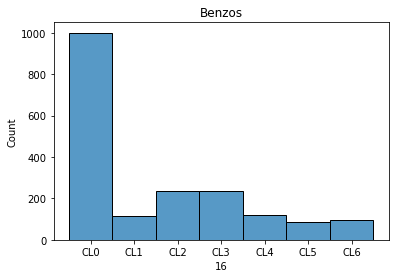

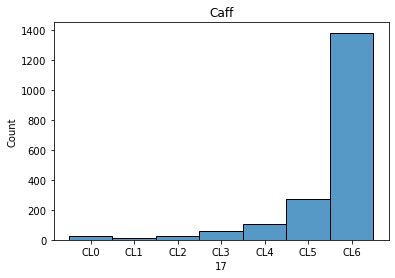

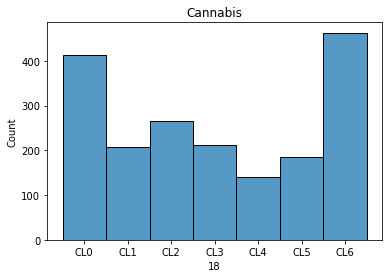

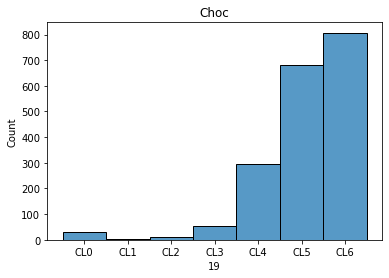

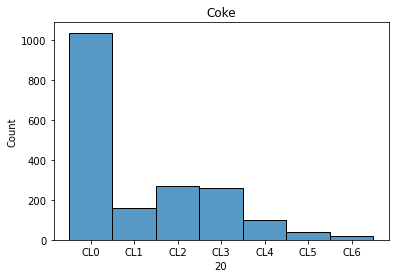

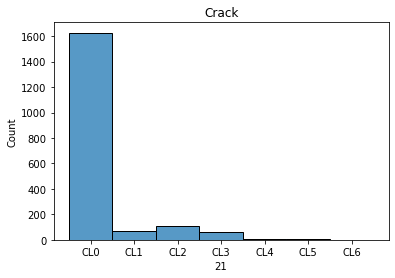

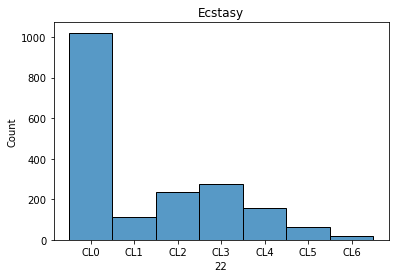

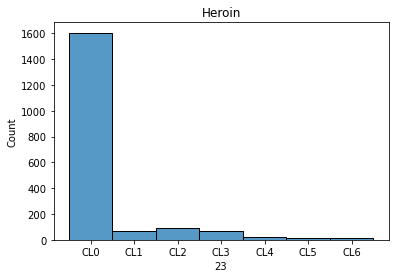

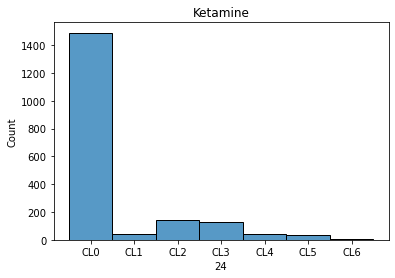

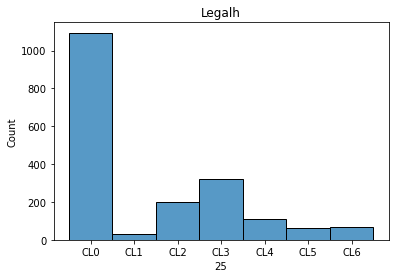

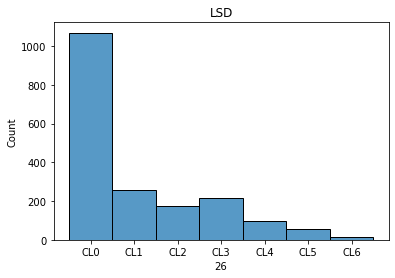

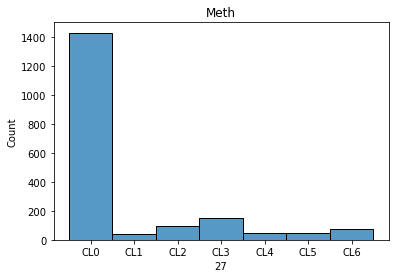

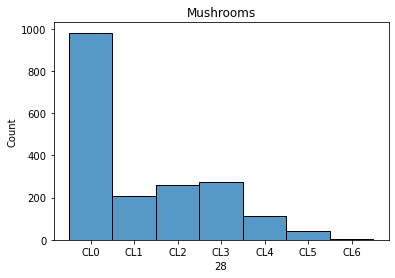

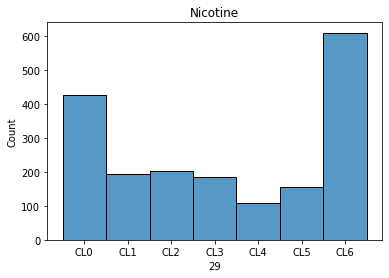

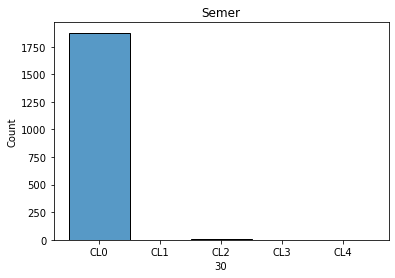

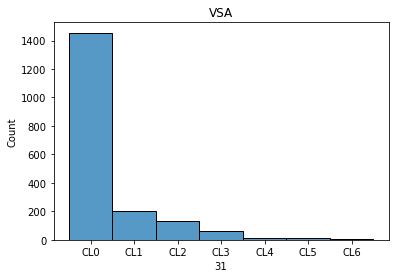

In [11]:
for col in data.columns:
    
    fig, ax = plt.subplots()
    sns.histplot(data=data, x=col, ax=ax)
    ax.set_title(dict_cols.get(col))
    plt.show()

Данные выглядят естетственно, что мы бы и ожидали в реальной жизни

### Обучение моделей

In [12]:
model = lgb.LGBMClassifier(class_weight="balanced", importance_type="gain" ,cv=5,random_state= RANDOM_STATE,scoring="f1_macro",
        n_jobs=-1, objective = 'multiclass')

#Lets try the same model for other
X = data[[1,2,3,4,5,6,7,8,9,10,11,12]]
y = data.drop(columns= X.columns)

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state = RANDOM_STATE)




model = lgb.LGBMClassifier(class_weight="balanced", importance_type="gain" ,cv=5,random_state= RANDOM_STATE,scoring="f1_macro",
        n_jobs=-1, objective = 'multiclass')

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2,random_state = RANDOM_STATE) #stratify = y


In [13]:
for col in y.columns:
    print('\033[1m', dict_cols.get(col),'\033[0m')
    
    y_train_ = y_train[col].copy()
    y_test_=y_test[col].copy()
    model.fit(X_train,y_train_)
    y_pred_=model.predict(X_test)
    macro_f1 = f1_score(y_test_, y_pred_, average='macro')
    print('Macro_f1:',macro_f1)
    print(classification_report(y_test_, y_pred_))

 Alcohol  
Macro_f1: 0.1489356078376325
              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00         5
         CL1       0.11      0.20      0.14         5
         CL2       0.00      0.00      0.00        15
         CL3       0.09      0.08      0.08        37
         CL4       0.15      0.17      0.16        60
         CL5       0.41      0.39      0.40       157
         CL6       0.26      0.26      0.26        98

    accuracy                           0.27       377
   macro avg       0.14      0.16      0.15       377
weighted avg       0.27      0.27      0.27       377

 Amphet 
Macro_f1: 0.23006469938040025
              precision    recall  f1-score   support

         CL0       0.68      0.56      0.61       187
         CL1       0.36      0.41      0.38        54
         CL2       0.18      0.23      0.20        43
         CL3       0.18      0.19      0.18        48
         CL4       0.07      0.05      0.06        19

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         CL0       0.75      0.72      0.73       255
         CL1       0.29      0.33      0.31        48
         CL2       0.28      0.24      0.26        46
         CL3       0.13      0.16      0.14        19
         CL4       0.00      0.00      0.00         3
         CL5       0.00      0.00      0.00         3
         CL6       0.00      0.00      0.00         3

    accuracy                           0.57       377
   macro avg       0.21      0.21      0.21       377
weighted avg       0.58      0.57      0.57       377

 Benzos 
Macro_f1: 0.2311000777593597
              precision    recall  f1-score   support

         CL0       0.69      0.54      0.61       206
         CL1       0.08      0.07      0.08        28
         CL2       0.14      0.26      0.18        38
         CL3       0.15      0.15      0.15        48
         CL4       0.15      0.19      0.17        21
         CL5       0.06      0.07      0

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         CL0       0.00      0.00      0.00         7
         CL1       0.00      0.00      0.00         1
         CL2       0.00      0.00      0.00         2
         CL3       0.00      0.00      0.00        10
         CL4       0.24      0.35      0.28        48
         CL5       0.35      0.34      0.34       137
         CL6       0.49      0.44      0.46       172

    accuracy                           0.37       377
   macro avg       0.15      0.16      0.16       377
weighted avg       0.38      0.37      0.37       377

 Coke 
Macro_f1: 0.25044406629678273
              precision    recall  f1-score   support

         CL0       0.74      0.58      0.65       209
         CL1       0.34      0.44      0.39        36
         CL2       0.33      0.35      0.34        54
         CL3       0.21      0.29      0.24        48
         CL4       0.12      0.15      0.14        20
         CL5       0.00      0.00      0.

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro_f1: 0.2096795731429511
              precision    recall  f1-score   support

         CL0       0.79      0.60      0.68       213
         CL1       0.10      0.19      0.13        16
         CL2       0.19      0.20      0.19        51
         CL3       0.22      0.34      0.27        50
         CL4       0.16      0.24      0.19        25
         CL5       0.00      0.00      0.00        16
         CL6       0.00      0.00      0.00         6

    accuracy                           0.44       377
   macro avg       0.21      0.22      0.21       377
weighted avg       0.51      0.44      0.46       377

 Heroin 
Macro_f1: 0.21414170723581688
              precision    recall  f1-score   support

         CL0       0.88      0.88      0.88       316
         CL1       0.29      0.26      0.28        19
         CL2       0.13      0.15      0.14        13
         CL3       0.18      0.23      0.20        13
         CL4       0.00      0.00      0.00         8
         C

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro_f1: 0.20728501727463108
              precision    recall  f1-score   support

         CL0       0.41      0.40      0.41        89
         CL1       0.21      0.30      0.25        37
         CL2       0.11      0.11      0.11        36
         CL3       0.09      0.09      0.09        34
         CL4       0.15      0.09      0.11        22
         CL5       0.08      0.08      0.08        37
         CL6       0.41      0.39      0.40       122

    accuracy                           0.28       377
   macro avg       0.21      0.21      0.21       377
weighted avg       0.29      0.28      0.28       377

 Semer 
Macro_f1: 1.0
              precision    recall  f1-score   support

         CL0       1.00      1.00      1.00       377

    accuracy                           1.00       377
   macro avg       1.00      1.00      1.00       377
weighted avg       1.00      1.00      1.00       377

 VSA 
Macro_f1: 0.1748684600182893
              precision    recall  f1-score

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Как видно, классы везде разбалансированы. Свдем задачу к бинарной классификации

#### Бинарная классификация


CL0 Never Used 

CL1 Used over a Decade Ago

CL2 Used in Last Decade 

CL3 Used in Last Year 

CL4 Used in Last Month 

CL5 Used in Last Week 

CL6 Used in Last Day

In [14]:
dict_binary = {'CL0':0,'CL1':1,'CL2':2,'CL3':3,'CL4':4,'CL5':5,'CL6':6}
target_columns = [_ for _ in range(13,32)]

In [15]:
def translate_to_binary(data,target_columns,dict_binary):
    df=data.copy()
    for col in target_columns:
        df[col] = df[col].map(dict_binary)
     
        df[col] = df[col].apply(lambda x: 0 if x in (0,1) else 1)
    return df

In [16]:
data_binary=translate_to_binary(data,target_columns,dict_binary)

In [17]:
drug_columns = [_ for _ in range(13,32)]
drug_columns

[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]

In [18]:
model = lgb.LGBMClassifier(class_weight="balanced", importance_type="gain" ,cv=5,random_state= RANDOM_STATE,scoring="f1",
        n_jobs=-1, objective = 'binary')

Возьмем метрику f1-macro weighted т.к. у нас классы разбалансированы. 

In [19]:
%%time
names=[]
f1_tr=[]
dummys=[]
f1_test=[]

scorer = make_scorer(f1_score, average='weighted')
model = lgb.LGBMClassifier(class_weight="balanced", importance_type="gain" ,cv=5,random_state= RANDOM_STATE,
        n_jobs=-1, objective = 'binary')

for col in tqdm(drug_columns):
#     print('\033[1m',dict_cols.get(col),'\033[0m')
    
    
    X=data_binary.drop(columns = col).copy()
    y = data_binary[col].copy()
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state = RANDOM_STATE,stratify = y)


    dummy_mod = DummyClassifier(random_state=42, 
                                    strategy='stratified'
                                    )
    
    dummy_mod.fit(X_train, y_train)
    names.append(dict_cols.get(col))
    
#     scorer = make_scorer(f1_score, average='weighted')
    f1_tr.append(cross_val_score(model, X_train, y_train, cv=5,scoring =scorer).mean())
    
    
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    
    f1_test.append(f1_score(y_pred,y_test,average='weighted'))
    dummys.append((f1_score(dummy_mod.predict(X_test),y_test,average='weighted')))
    
    
data_={'drug':names,'cross_val_mean':f1_tr,'f1_test':f1_test,'dummys':dummys}
df_=pd.DataFrame(data_)
display(df_)


print('cross_val_mean: ', df_['cross_val_mean'].mean())
print('final_f1_test_mean: ', df_['f1_test'].mean())
print('final_dummy_mean: ', df_['dummys'].mean())

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:07<00:00,  2.61it/s]


,drug,cross_val_mean,f1_test,dummys
0,Alcohol,0.943463,0.965193,0.941470
1,Amphet,0.814623,0.817356,0.521925
2,Amyl,0.821702,0.825845,0.662245
3,Benzos,0.779709,0.760823,0.474801
4,Caff,0.966580,0.962865,0.978709
5,Cannabis,0.863673,0.855198,0.576233
6,Choc,0.968238,0.986652,0.978709
7,Coke,0.841955,0.837378,0.558105
8,Crack,0.888371,0.891771,0.812788
9,Ecstasy,0.861508,0.858914,0.485411


cross_val_mean:  0.866572010668347
final_f1_test_mean:  0.8680652795256311
final_dummy_mean:  0.691672609812006
Wall time: 7.3 s


Проверим где мы предсказали хуже Dummy

In [20]:
df_[df_['dummys'] > df_['f1_test']]

,drug,cross_val_mean,f1_test,dummys
4,Caff,0.96658,0.962865,0.978709


**Выводы**

В данном ноутбуке была обучена модель градиентного бустинга для мультитаргета. Затем таргеты были преобразованы в бинарные и модель обучена на них. Использована метрика f1_macro_weighted.Мы превзошли бейзлайн от Dummy с помощью нашей модели

** Можно улучшить ** 
1.В реальных условиях лучше уточнить какую задачу хочет решить заказчик и подберу более точную метрику поскольку таргеты у нас по смыслу очень разные (коффе употребляют почти все , а героин почти никто, а мы усредняем это одинаково)


2.Можно сделать тюнинг гиперпарамтеров оптюной, автомлем для пониманя какой скор мы можем выжать.


3.Использовать shap для интерпритации

4.Вынести большие функции в отедльный .py файл